# The Korteweg-de Vries Equation
This notebook demonstrates KAN-PDE on the KdV equation
\begin{align}
    u_t = - u_{xxx}-6 uu_x.
\end{align}
The dataset can be downloaded from [PDE-FIND](https://github.com/snagcliffs/PDE-FIND/tree/master/Datasets).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, scipy, scipy.io, sys, torch
import torch.nn as nn

from matplotlib import cm
from torchdiffeq import odeint_adjoint as torchodeint
from tqdm import tqdm
from efficient_kanpde import *

In [2]:
# Define device
device = torch.device('cpu')

# Define output directory
odir = "plots_kdv/"
os.makedirs(odir, exist_ok=True)

## Loading the dataset
The dataset can be downloaded from [PDE-FIND](https://github.com/snagcliffs/PDE-FIND/tree/master/Datasets).

In [3]:
f = scipy.io.loadmat('datasets/PDE_FIND/kdv.mat')
subsample = 8 

u = f['usol'].T[:,::subsample] # (nt, nx) = (201, 64)
x = f['x'].flatten()[::subsample]
t = f['t'].flatten()

u_true = torch.Tensor(np.real(u)).to(device)
u_true.requires_grad = True

nt_train = 40 # number of training steps
u0_train = u_true[:1,]
u0_test = u_true[nt_train:nt_train+1,]

u_train = u_true[:nt_train, :]
u_test = u_true[nt_train:, :]

ts = torch.Tensor(t).to(device)
t_train = ts[:nt_train]
t_test = ts[nt_train:,]

xmesh, tmesh = np.meshgrid(x, t[nt_train:])

os.makedirs("plots/", exist_ok=True)
mpath = "plots/kdv/"
os.makedirs(mpath, exist_ok=True)


## Defining Helper functions

In [4]:
def plot_test_evolution(y_pred, y_test, path):
    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    c = axes[0].pcolor(xmesh, tmesh, y_pred.detach().cpu(), cmap='coolwarm')
    axes[0].set_title('Solution u')
    fig.colorbar(c)
    
    diff = (y_pred - y_test).abs()
    c = axes[1].pcolor(xmesh, tmesh, diff.detach().cpu(), cmap='coolwarm')
    axes[1].set_title('Abs. Difference')
    fig.colorbar(c)

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('t')

    plt.tight_layout()
    plt.savefig(odir+f"epoch_{epoch}.png", dpi=200, facecolor="w", edgecolor="w", orientation="portrait")
    plt.close('all')


def save_loss(loss_list_train, loss_list_test, path):
    plt.figure(figsize=(3,3))
    plt.semilogy(np.arange(num_epochs), torch.Tensor(loss_list_train), label='train')
    plt.semilogy(np.arange(num_epochs)[::print_freq], torch.Tensor(loss_list_test), label='test')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(path+'loss.png', dpi=200, facecolor="w", edgecolor="w", orientation="portrait")

    data = pd.DataFrame(index = np.arange(num_epochs), columns=['train', 'test'])
    data['train'] = torch.Tensor(loss_list_train).numpy()
    data.loc[::print_freq, 'test'] = torch.Tensor(loss_list_test).numpy()
    data.to_csv(path+'loss.csv')


def calDeriv(t, X):
    dXdt = model(X)
    return dXdt

## Initialization

In [5]:
model = KANPDE(
    layers_hidden = [[5,2]],  # one hidden layer with 7 nodes, 5 for summation and 2 for multiplication
    dx = 1,             # spatial grid size in x to compute the spatial derivatives  
    pde_order = 4,      # order of the highest spatial derivative 
    pde_component = 1,  # number of components in the PDE system
    is_periodic = True, # whether to apply periodic boundary condition for spatial derivatives 
    spatial_dim = 1,    # spatial dimension
    ).to(device) 
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

520


In [6]:
num_epochs = 101
plot_freq = 50
print_freq = 10

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_list_train = []
loss_list_test = []

adjoint_params = [model.layers[l].spline_weight for l in range(model.depth)] + [model.layers[l].base_weight for l in range(model.depth)]

## Training

Epoch 0000 | Train Loss 0.009531 | Total Loss 0.046004
Epoch 0010 | Train Loss 0.006680 | Total Loss 0.017274
Epoch 0020 | Train Loss 0.004332 | Total Loss 0.010682
Epoch 0030 | Train Loss 0.002762 | Total Loss 0.008608
Epoch 0040 | Train Loss 0.001417 | Total Loss 0.005973
Epoch 0050 | Train Loss 0.000920 | Total Loss 0.020813
Epoch 0060 | Train Loss 0.000671 | Total Loss 0.006425
Epoch 0070 | Train Loss 0.000566 | Total Loss 0.005397
Epoch 0080 | Train Loss 0.000467 | Total Loss 0.005203
Epoch 0090 | Train Loss 0.000427 | Total Loss 0.004297
Epoch 0100 | Train Loss 0.000403 | Total Loss 0.003781


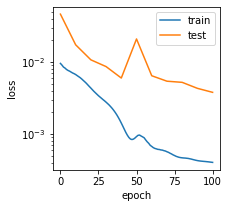

In [7]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    pred = torchodeint(calDeriv, u0_train, t_train, adjoint_params=adjoint_params, method="dopri5", options={"min_step": 0.01}).to(device) 

    loss_train = torch.mean(torch.square(pred[:, 0, :] - u_train))
    loss_train.backward()
    optimizer.step()
    loss_list_train.append(loss_train.detach().cpu())

    if epoch % print_freq == 0:
        model.eval()
        with torch.no_grad():
            pred_test = torchodeint(calDeriv, u0_test, t_test, adjoint_params=[], method="dopri5", options={"min_step": 0.01})    
            loss_test = torch.mean(torch.square(pred_test[:,0, :] - u_test))
            loss_list_test.append(loss_test.detach().cpu())
            print(f'Epoch {epoch:04d} | Train Loss {loss_train.item():.6f} | Total Loss {loss_test.item():.6f}')
            if epoch % plot_freq == 0:
                plot_test_evolution(pred_test[:,0,:], u_test, f"{odir}/")
                torch.save(model.state_dict(), f'{odir}/final_model.pt')

model.eval()
with torch.no_grad():
    pred_test = torchodeint(calDeriv, u0_test, t_test, adjoint_params=[])    
    plot_test_evolution(pred_test[:,0,:], u_test, f"{odir}/")
save_loss(loss_list_train, loss_list_test, f'{odir}/')
torch.save(model.state_dict(), f'{odir}/final_model.pt')